In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to your Sedimentary rock dataset
dataset_dir = '/content/drive/MyDrive/datasets/Sedimentary'  # update path

# List class folders
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir,d))]
print("Classes found:", classes)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Classes found: ['Limestone', 'Sandstone', 'Coal']


In [ ]:
total_images = 0
class_counts = []

for cls in classes:
    cls_path = os.path.join(dataset_dir, cls)
    count = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg','.jpeg','.png'))])
    print(f"Class '{cls}' has {count} images")
    total_images += count
    class_counts.append(count)

print("Total images in dataset:", total_images)


Class 'Limestone' has 331 images
Class 'Sandstone' has 323 images
Class 'Coal' has 369 images
Total images in dataset: 1023


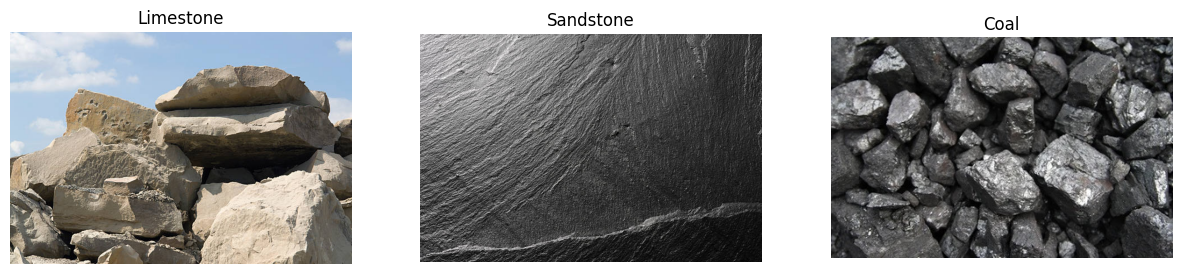

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

plt.figure(figsize=(15,5))
for i, cls in enumerate(classes):
    cls_path = os.path.join(dataset_dir, cls)
    images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    img_name = random.choice(images)
    img_path = os.path.join(cls_path, img_name)
    img = mpimg.imread(img_path)
    plt.subplot(1, len(classes), i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    validation_split=0.2
)

# Training generator
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    color_mode='rgb'
)

# Validation generator
val_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    color_mode='rgb'
)


Found 820 images belonging to 3 classes.
Found 203 images belonging to 3 classes.


In [ ]:
x_batch, y_batch = next(train_generator)
print("Batch shape (images):", x_batch.shape)   # (32,128,128,3)
print("Batch shape (labels):", y_batch.shape)   # (32,3)
print("Min pixel value:", x_batch.min())
print("Max pixel value:", x_batch.max())
print("Data type after preprocessing:", x_batch.dtype)


Batch shape (images): (32, 128, 128, 3)
Batch shape (labels): (32, 3)
Min pixel value: 0.0
Max pixel value: 1.0
Data type after preprocessing: float32


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Input(shape=(128,128,3)),  # Explicit input layer
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')  # 3 classes
])


In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator
)


Epoch 1/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5200 - loss: 1.0010 - val_accuracy: 0.6059 - val_loss: 0.7948
Epoch 2/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7196 - loss: 0.6493 - val_accuracy: 0.6355 - val_loss: 0.7743
Epoch 3/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7523 - loss: 0.6297 - val_accuracy: 0.7931 - val_loss: 0.6396
Epoch 4/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7840 - loss: 0.5537 - val_accuracy: 0.7833 - val_loss: 0.6223
Epoch 5/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7482 - loss: 0.5998 - val_accuracy: 0.7783 - val_loss: 0.6143
Epoch 6/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7970 - loss: 0.4773 - val_accuracy: 0.7833 - val_loss: 0.5695
Epoch 7/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8112 - loss: 0.5036 - val_accuracy: 0.7537 - val_loss: 0.6508
Epoch 8/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8041 - loss: 0.5508 - val_accuracy: 0.7783 - val_loss:

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Flatten(),
    Dense(64, activation='relu'),  # smaller dense layer
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_31 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,700,035 (6.49 MB)

 Trainable params: 1,699,587 (6.48 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 820 images belonging to 3 classes.
Found 203 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


In [ ]:
history = model.fit(
    train_generator,
    epochs=30,           # more epochs, but early stopping will prevent overfitting
    validation_data=val_generator,
    callbacks=[early_stop]
)


Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 984ms/step - accuracy: 0.6234 - loss: 3.0607 - val_accuracy: 0.3251 - val_loss: 2.1366
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 936ms/step - accuracy: 0.7542 - loss: 2.5419 - val_accuracy: 0.3251 - val_loss: 2.0971
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 929ms/step - accuracy: 0.7140 - loss: 1.6725 - val_accuracy: 0.3399 - val_loss: 1.2444
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 929ms/step - accuracy: 0.7697 - loss: 1.5190 - val_accuracy: 0.3300 - val_loss: 2.1478
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 932ms/step - accuracy: 0.7989 - loss: 1.8155 - val_accuracy: 0.3350 - val_loss: 1.6724
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 930ms/step - accuracy: 0.7769 - loss: 1.0342 - val_accuracy: 0.4778 - val_loss: 2.5314
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 920ms/step - accuracy: 0.7860 - loss: 1.5319 - val_accuracy: 0.3941 - val_loss: 3.3426
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 927ms/step - accuracy: 0.7522 - loss: 3.2500 - val_accu

improve validation accuracy also used ReduceLROnPlateau from tensorflow

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),

    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)


In [ ]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 627ms/step - accuracy: 0.5196 - loss: 1.3220 - val_accuracy: 0.6798 - val_loss: 0.7681 - learning_rate: 0.0010
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 591ms/step - accuracy: 0.7137 - loss: 0.6836 - val_accuracy: 0.7438 - val_loss: 0.6905 - learning_rate: 0.0010
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 594ms/step - accuracy: 0.7098 - loss: 0.6150 - val_accuracy: 0.7635 - val_loss: 0.6707 - learning_rate: 0.0010
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 605ms/step - accuracy: 0.7553 - loss: 0.5782 - val_accuracy: 0.8030 - val_loss: 0.6608 - learning_rate: 0.0010
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 598ms/step - accuracy: 0.7242 - loss: 0.6473 - val_accuracy: 0.7931 - val_loss: 0.6073 - learning_rate: 0.0010
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 588ms/step - accuracy: 0.7370 - loss: 0.6176 - val_accuracy: 0.7734 - val_loss: 0.6352 - learning_rate: 0.0010
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 673ms/step - accuracy: 0.7993 - loss: 0.

In [ ]:
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 382ms/step - accuracy: 0.8386 - loss: 0.5174
Validation Loss: 0.6004
Validation Accuracy: 0.8030


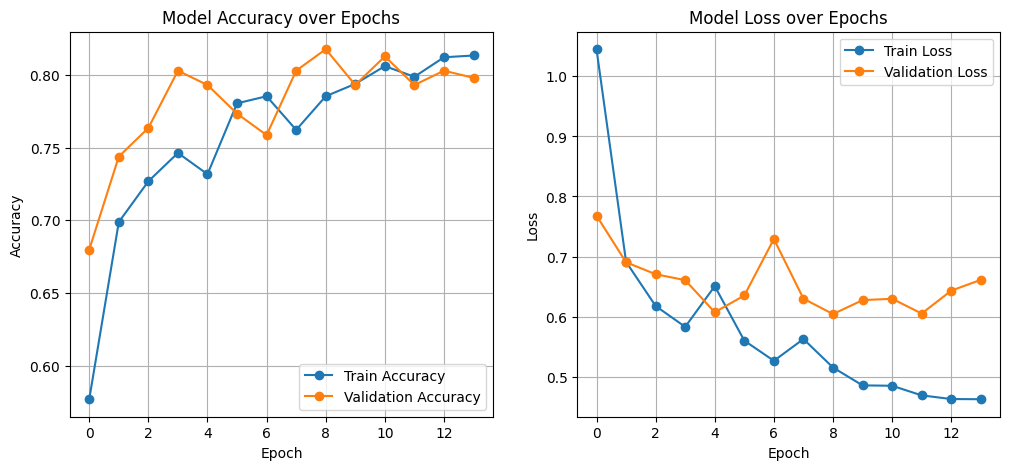

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()


In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Create a folder to save the model
save_path = '/content/drive/MyDrive/Sedimentary_CNN'
os.makedirs(save_path, exist_ok=True)

# Save the model
model_file = os.path.join(save_path, 'cnn_model.h5')
model.save(model_file)
print(f"✅ Model saved at: {model_file}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model saved at: /content/drive/MyDrive/Sedimentary_CNN/cnn_model.h5
